In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy

## Part 1 ‑ Exploratory data analysis

The data is stored in a json file. We first extract the json string and then use json_normalize to output a DataFrame object  

In [2]:
with open('logins.json') as logins_file:
    logins_string = json.load(logins_file)
    logins_df = json_normalize(logins_string,'login_time')

Since the data is a time series type we convert the single column of the DataFrame to Datetime and set it as the DataFrame Index. Lastly we create a column of '1's which is used later for aggregating the data

In [3]:
logins_df = pd.to_datetime(logins_df.iloc[:,0]).to_frame()
logins_df = logins_df.rename(columns={0:"login_time"})
logins_df.set_index('login_time', inplace=True)
logins_df['logins_made'] = 1

In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
logins_made    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


The above shows that the data is from January 01, 1970 to April 13, 1970

In [5]:
logins_df = logins_df.groupby(pd.Grouper(freq='15min')).aggregate(numpy.sum)

In [6]:
logins_df.mean()

logins_made    9.515938
dtype: float64

During the entire period on average there are 9.5 logins in a 15 mninute interval

In [7]:
logins_df.groupby(logins_df.index.hour).mean().plot(kind='bar')

On average during the entire period from 01/01/1970 to 04/13/1970 their is a sharp decline in user logins between the times 6:00 am to 9:00 am. This may indicate an issue that merits further investigation or maybe this is generally a low demand period.
9:00 pm to 4:00 am are peak hours. In addition there is a peak at 11:00 am and 12 noon (lunch time?).

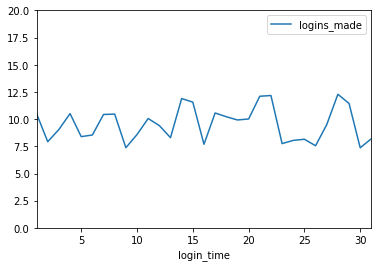

In [8]:
logins_df.groupby(logins_df.index.day).mean().plot(ylim=(0,20))

Looking at average 15 minute interval logins each day during the course of each month does not reveal any anomolies and shows that in general there are approximately between 7.15 to 12.5 logins in a 15 minute internval. Now let's look at the overall behavior each day of the week during the entire time period from Jan 01, 1970 to April 13, 1970 

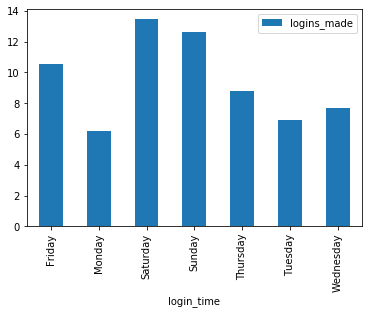

In [9]:
logins_df.groupby(logins_df.index.weekday_name).mean().plot(kind='bar')

Looks like there's more demand on the weekends. There's also relatively more demand on Friday compared to other days of the weekday.

In [10]:
friday = logins_df[logins_df.index.weekday_name == 'Friday']
saturday = logins_df[logins_df.index.weekday_name == 'Saturday']
sunday = logins_df[logins_df.index.weekday_name == 'Sunday']
weekday = logins_df[logins_df.index.dayofweek < 5]

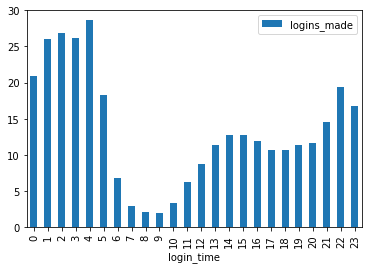

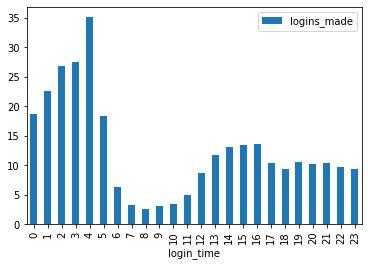

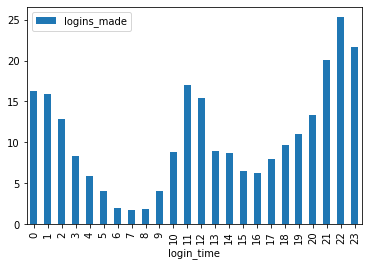

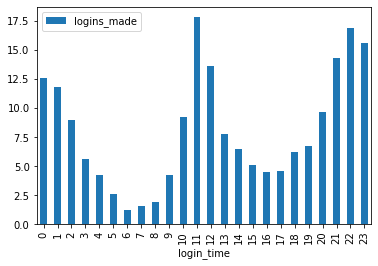

In [11]:
saturday.groupby(friday.index.hour).mean().plot(kind='bar')
sunday.groupby(friday.index.hour).mean().plot(kind='bar')
friday.groupby(friday.index.hour).mean().plot(kind='bar')
weekday.groupby(weekday.index.hour).mean().plot(kind='bar')

Demand patterns on the weekend is different from that during the weekday. Weekends are busy from midnight to 5:00 am with highest demand at 4:00 am. Sunday evening demand is much lesser than Saturday evening.

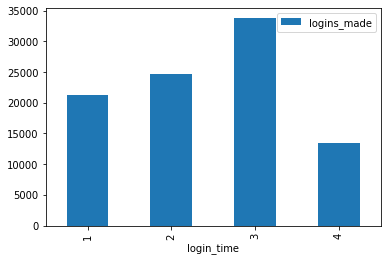

In [12]:
logins_df.groupby(logins_df.index.month).sum()[0:4].plot(kind='bar')

During Q1 (Jan-Mar) the total number of logins in a month have been steadily increasing. We only have data for almost half of April however even if we interpolate the numbers there is a dip from 34K logins to 27K (13.5K *2) logins from March to April. This root cause of this dip should be investigated.

,logins_made
0.01,0.0
0.25,3.0
0.50,7.0
0.75,13.0
0.99,38.0


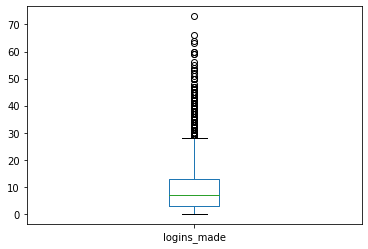

In [13]:
logins_df.plot(kind='box')
logins_df.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

Based on the fact that number of instances where at least 38 logins we made in a 15 minute interval account for 1% of the instances where any number of logins were made in a 15 minute interval, it would also merit to look at the 15 minute intervals where there were 38 or more logins made. See if anything special happened on those days ( e.g. promotion )

In [14]:
outliers = logins_df.loc[logins_df.index[logins_df['logins_made'] >= 38]]

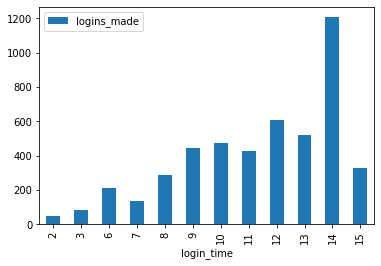

In [15]:
outliers.groupby(outliers.index.week).sum().plot(kind='bar')

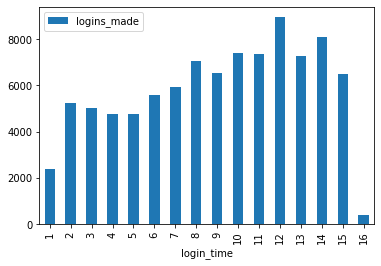

In [16]:
logins_df.groupby(logins_df.index.week).aggregate(numpy.sum).plot(kind='bar')

Comparing the above two graphs show that on week 14 (compared to previous weeks) there was a sharp increase in thetotal number of logins in instances where more than 37 logins were made during a 15 minute interval whereas the overall number of logins showed a relatively minor change during week 14 when compared to previous weeks.  

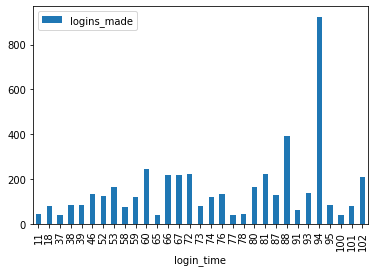

In [17]:
df = logins_df.loc[logins_df.index[logins_df.logins_made >= 38]].sort_index()
df.groupby(df.index.dayofyear).sum().plot(kind='bar')

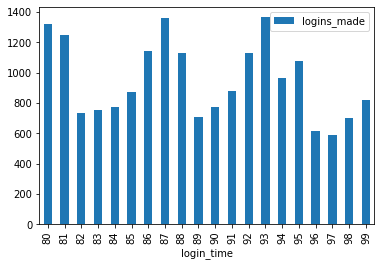

In [18]:
logins_90_100 = logins_df.loc[(logins_df.index.dayofyear < 100) & (logins_df.index.dayofyear >= 80) & (logins_df.logins_made < 38)]
logins_90_100.groupby(logins_90_100.index.dayofyear).sum().plot(kind='bar')

On day 94 of the year (Sunday April 4, 1970) there were 924 logins made when only looking at instances where 38 or more logins were made in a 15 minute interval. However setting those outliers aside the number of logins actually decreased on April 4 compared to the previous and next day. I would in general check with other departments as to if anything special happend on April 4th, 1970 and Monday March 29, 1970 (day 88).

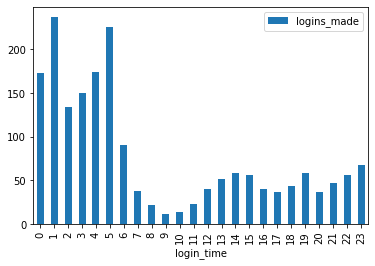

In [19]:
d94 = logins_df[logins_df.index.dayofyear == 94]
d94.groupby(d94.index.hour).sum().plot(kind='bar')

It terms of the number of logins on April 4 the relative hourly distribution appears to be like any other Sunday. 